In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('Stars.csv')

print(df.shape)
df.head()

(240, 7)


,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [3]:
df.describe()

,Temperature,L,R,A_M,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


# EDA

## Target

In [4]:
target = 'Type'

### Distribution

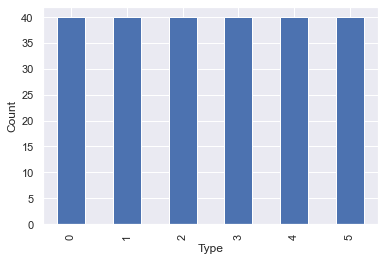

In [5]:
df.groupby(target)['L'].count().plot.bar()

plt.ylabel('Count')
plt.show()

## Missing Values

In [6]:
df.isnull().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

## Numerical Features

In [7]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O' and feature != target]

df[num_features].head()

,Temperature,L,R,A_M
0,3068,0.002400,0.1700,16.12
1,3042,0.000500,0.1542,16.60
2,2600,0.000300,0.1020,18.70
3,2800,0.000200,0.1600,16.65
4,1939,0.000138,0.1030,20.06


### Distribution

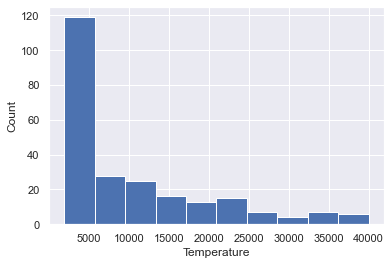

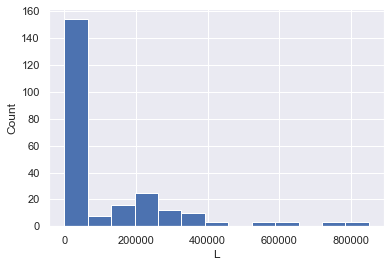

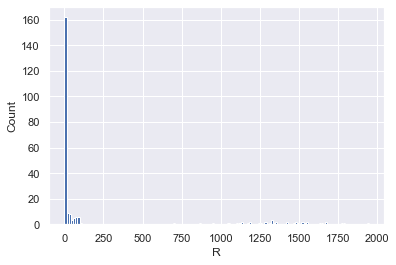

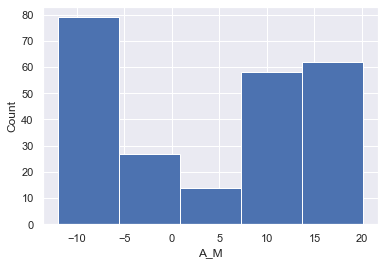

In [8]:
for feature in num_features:
    iqr = stats.iqr(df[feature], interpolation = 'midpoint')
    h = (2 * iqr) / (len(df[feature]) ** (1/3))
    bins = round((max(df[feature]) - min(df[feature])) / h)
    
    df[feature].hist(bins = bins)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

### Outliers

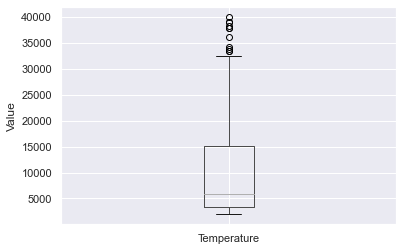

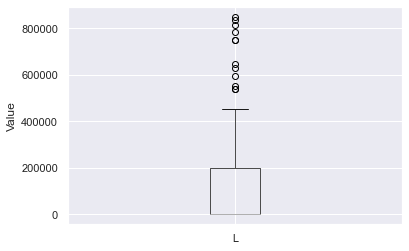

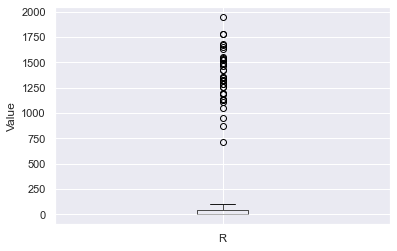

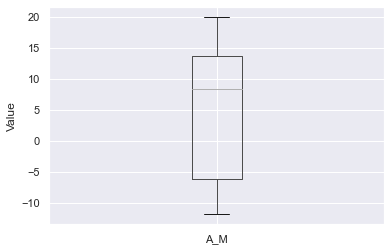

In [9]:
for feature in num_features:
    df.boxplot(column = feature)
    plt.ylabel('Value')
    plt.show()

In [10]:
extreme = df['R'].median() + 0.5 * df['R'].std()

print('values to replace: {}%'.format(len(df.loc[df['R'] > extreme]) * 100 / len(df)))

values to replace: 16.666666666666668%


In [11]:
data = df.copy()

In [12]:
data['R'] = np.where(data['R'] > extreme, extreme, data['R'])

### vs Target

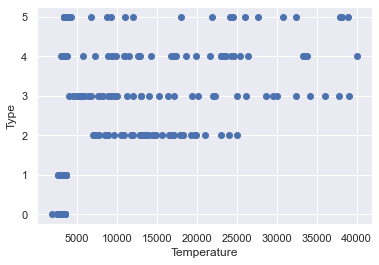

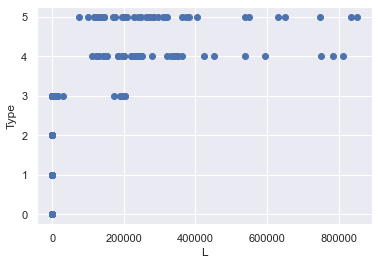

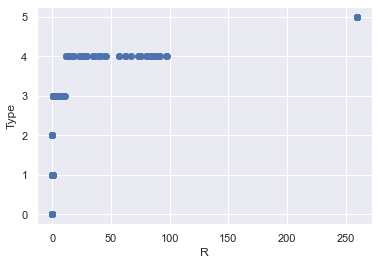

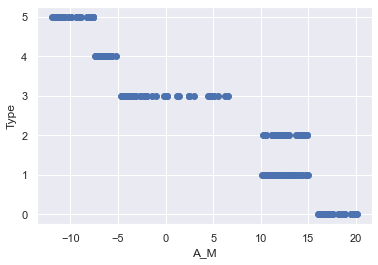

In [13]:
for feature in num_features:
    plt.scatter(data[feature], data[target])
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

### Inferences

1. If temperature is less than 5000 then star will definitely belong to Type 0 or Type 1: 
  
2. If L value = 0 then star will definitely belong to Type 0, Type 1 or Type 2
        
3.  - If R value = 0 then star will definitely belong to Type 0, Type 1 or Type 2
    - If R value > 250 then star will definitely belong to Type 5
  
4.  - If A_M value > 15 then star will definitely belong to Type 0
    - If A_M value >= 10 or A_M value <= 15 then star will definitely belong to Type 1 or Type 2
    - If A_M value > -5 or A_M value < 10 then star will definitely belong to Type 3

### Transformation

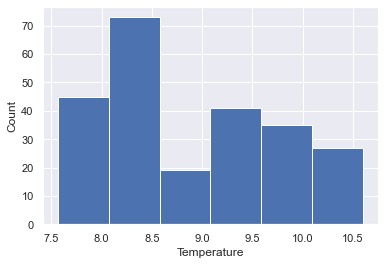

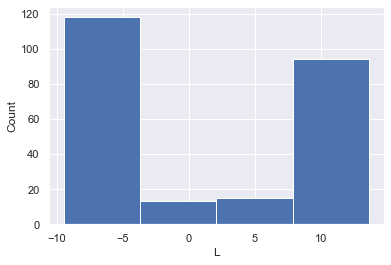

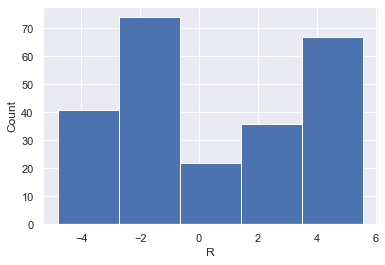

In [14]:
for feature in num_features[:-1]:
    data[feature] = np.log(data[feature])
    
    iqr = stats.iqr(data[feature], interpolation = 'midpoint')
    h = (2 * iqr) / (len(data[feature]) ** (1/3))
    bins = round((max(data[feature]) - min(data[feature])) / h)
    
    data[feature].hist(bins = bins)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

## Categorical Features

In [15]:
cat_features = [feature for feature in data.columns if feature not in num_features and feature != target]

data[cat_features].head()

,Color,Spectral_Class
0,Red,M
1,Red,M
2,Red,M
3,Red,M
4,Red,M


### Distribution

In [16]:
for feature in cat_features:
    print('{}: {} categories'.format(feature, len(data[feature].unique())))
    print(data[feature].unique())

Color: 17 categories
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']
Spectral_Class: 7 categories
['M' 'B' 'A' 'F' 'O' 'K' 'G']


In [17]:
idx = data.loc[(data['Color'] == 'Blue white') | (data['Color'] == 'Blue-white') | (data['Color'] == 'Blue-White')].index
data.loc[idx, 'Color'] = 'Blue White'

In [18]:
idx = data.loc[data['Color'] == 'white'].index
data.loc[idx, 'Color'] = 'White'

In [19]:
idx = data.loc[(data['Color'] == 'yellowish') | (data['Color'] == 'Yellowish')].index
data.loc[idx, 'Color'] = 'Yellow'

In [20]:
idx = data.loc[data['Color'] == 'Yellowish White'].index
data.loc[idx, 'Color'] = 'White-Yellow'

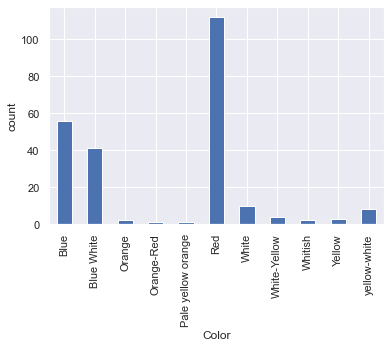

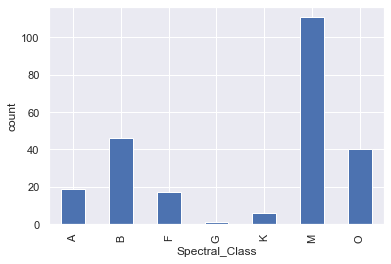

In [21]:
for feature in cat_features:
    data.groupby(feature)[target].count().plot.bar()
    plt.ylabel('count')
    plt.show()

In [22]:
cat_3_only = ['yellow-white', 'Yellow', 'Whitish', 'Orange-Red']
cat_2_only = ['Pale yellow orange', 'White-Yellow']
cat_5_only = 'Orange'

In [23]:
idx = data.loc[(data['Color'] == 'yellow-white') | (data['Color'] == 'Yellow') | (data['Color'] == 'Whitish') | (data['Color'] == 'Orange-Red')].index
data.loc[idx, 'Color'] = 'cat_3_only'

In [24]:
idx = data.loc[(data['Color'] == 'Pale yellow orange') | (data['Color'] == 'White-Yellow')].index
data.loc[idx, 'Color'] = 'cat_2_only'

In [25]:
for feature in cat_features:
    print('{}: {} categories'.format(feature, len(data[feature].unique())))
    print(data[feature].unique())

Color: 7 categories
['Red' 'Blue White' 'White' 'cat_2_only' 'Blue' 'cat_3_only' 'Orange']
Spectral_Class: 7 categories
['M' 'B' 'A' 'F' 'O' 'K' 'G']


### vs Target Variable

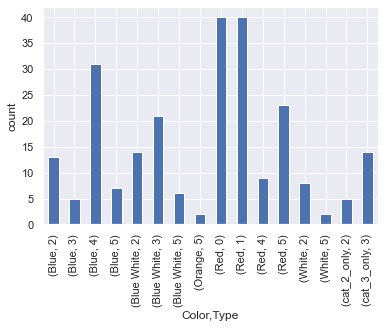

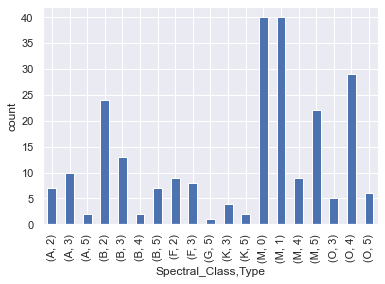

In [27]:
for feature in cat_features:
    data.groupby([feature, target])['L'].count().plot.bar()
    plt.ylabel('count')
    plt.show()

### Inferences

1. If a star has the color Pale yellow orange or White-Yellow it will definitely belong to Type 2
2. If a star has th color yellow-white, Yellow, Whitish or Orange-Red it will definitely belong to Type 3
3. If a star has the color Orange it will definitely belong to Type 5
4. If a star has the spectral type 'G' then it will definitely belong to Type 5:

# Feature Engineering

In [28]:
df = pd.read_csv('Stars.csv')

print(df.shape)
df.head()

(240, 7)


,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


## Numerical Features

In [29]:
extreme = df['R'].median() + 0.5 * df['R'].std()

df['R'] = np.where(df['R'] > extreme, extreme, df['R'])

In [30]:
for feature in num_features[:-1]:
    df[feature] = np.log(df[feature])

## Categorical Features

In [31]:
idx = df.loc[(df['Color'] == 'Blue white') | (df['Color'] == 'Blue-white') | (df['Color'] == 'Blue-White')].index
df.loc[idx, 'Color'] = 'Blue White'

In [32]:
idx = df.loc[df['Color'] == 'white'].index
df.loc[idx, 'Color'] = 'White'

In [33]:
idx = df.loc[(df['Color'] == 'yellowish') | (df['Color'] == 'Yellowish')].index
df.loc[idx, 'Color'] = 'Yellow'

In [34]:
idx = df.loc[df['Color'] == 'Yellowish White'].index
df.loc[idx, 'Color'] = 'White-Yellow'

In [35]:
cat_3_only = ['yellow-white', 'Yellow', 'Whitish', 'Orange-Red']
cat_2_only = ['Pale yellow orange', 'White-Yellow']

In [36]:
idx = df.loc[(df['Color'] == 'yellow-white') | (df['Color'] == 'Yellow') | (df['Color'] == 'Whitish') | (df['Color'] == 'Orange-Red')].index
df.loc[idx, 'Color'] = 'cat_3_only'

In [37]:
idx = df.loc[(df['Color'] == 'Pale yellow orange') | (df['Color'] == 'White-Yellow')].index
df.loc[idx, 'Color'] = 'cat_2_only'

In [38]:
for feature in cat_features:
    print('{}: {} categories'.format(feature, len(df[feature].unique())))
    print(df[feature].unique())

Color: 7 categories
['Red' 'Blue White' 'White' 'cat_2_only' 'Blue' 'cat_3_only' 'Orange']
Spectral_Class: 7 categories
['M' 'B' 'A' 'F' 'O' 'K' 'G']


In [39]:
dummy_df = pd.get_dummies(df, drop_first = True)
dummy_df.head()

,Temperature,L,R,A_M,Type,Color_Blue White,Color_Orange,Color_Red,Color_White,Color_cat_2_only,Color_cat_3_only,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,8.028781,-6.032287,-1.771957,16.12,0,0,0,1,0,0,0,0,0,0,0,1,0
1,8.020270,-7.600902,-1.869505,16.60,0,0,0,1,0,0,0,0,0,0,0,1,0
2,7.863267,-8.111728,-2.282782,18.70,0,0,0,1,0,0,0,0,0,0,0,1,0
3,7.937375,-8.517193,-1.832581,16.65,0,0,0,1,0,0,0,0,0,0,0,1,0
4,7.569928,-8.888257,-2.273026,20.06,0,0,0,1,0,0,0,0,0,0,0,1,0


# Feature Selection

In [40]:
X = dummy_df.drop(target, axis = 1)
y = dummy_df[target]

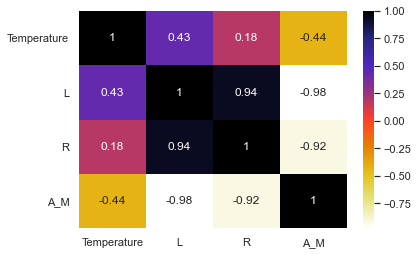

In [41]:
cor = X[num_features].corr()

sns.heatmap(cor, annot = True, cmap = plt.cm.CMRmap_r)
plt.show()

In [42]:
X.drop(['R'], axis = 1, inplace = True)

# Models

In [43]:
scores = {}

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## RandomForestClassifier

In [45]:
model = RandomForestClassifier()

In [46]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [47]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 7  0  0  0  0  0]
 [ 0  9  0  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  0  8  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         6

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [48]:
scores['RandomForest Classifier'] = model.score(X_test, y_test)

## XGBoost

In [49]:
model = XGBClassifier(use_label_encoder = False)

model.fit(X_train, y_train)

[21:44:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [50]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 7  0  0  0  0  0]
 [ 0  9  0  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  0  8  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  0  0  0  6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         6

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [51]:
scores['XGBoost Classifier'] = model.score(X_test, y_test)

## Scaling

In [52]:
scaler = MinMaxScaler()

scaler.fit(X_train)

MinMaxScaler()

In [53]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

In [54]:
model = LogisticRegression()

model.fit(X_train_scaled, y_train)

LogisticRegression()

In [55]:
y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7 0 0 0 0 0]
 [5 4 0 0 0 0]
 [0 0 7 0 0 0]
 [0 0 0 8 0 0]
 [0 0 0 0 9 2]
 [0 0 0 2 0 4]]
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       1.00      0.44      0.62         9
           2       1.00      1.00      1.00         7
           3       0.80      1.00      0.89         8
           4       1.00      0.82      0.90        11
           5       0.67      0.67      0.67         6

    accuracy                           0.81        48
   macro avg       0.84      0.82      0.80        48
weighted avg       0.86      0.81      0.81        48



In [56]:
scores['Logistic Regression'] = model.score(X_test_scaled, y_test)

## KNN

In [82]:
n_score = []
n_neighbors = [3, 4, 5, 6, 7, 8, 9, 10]

for n in n_neighbors:
    model = KNeighborsClassifier(n_neighbors = n)
    model.fit(X_train_scaled, y_train)
    n_score.append(model.score(X_test_scaled, y_test))
    
best_neighbors = n_neighbors[n_score.index(max(n_score))]
print('Best Neighbors = {}'.format(best_neighbors))

Best Neighbors = 3


In [83]:
model = KNeighborsClassifier(n_neighbors = best_neighbors)

model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [84]:
y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7 0 0 0 0 0]
 [0 9 0 0 0 0]
 [0 0 7 0 0 0]
 [0 0 0 8 0 0]
 [0 0 0 2 9 0]
 [0 0 0 0 0 6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         7
           3       0.80      1.00      0.89         8
           4       1.00      0.82      0.90        11
           5       1.00      1.00      1.00         6

    accuracy                           0.96        48
   macro avg       0.97      0.97      0.96        48
weighted avg       0.97      0.96      0.96        48



In [85]:
scores['KNN'] = model.score(X_test_scaled, y_test)

## SVM

In [86]:
model = SVC(kernel = 'poly')

model.fit(X_train_scaled, y_train)

SVC(kernel='poly')

In [87]:
y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7 0 0 0 0 0]
 [0 9 0 0 0 0]
 [0 0 7 0 0 0]
 [0 0 0 8 0 0]
 [0 0 0 0 9 2]
 [0 0 0 2 0 4]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         7
           3       0.80      1.00      0.89         8
           4       1.00      0.82      0.90        11
           5       0.67      0.67      0.67         6

    accuracy                           0.92        48
   macro avg       0.91      0.91      0.91        48
weighted avg       0.92      0.92      0.92        48



In [88]:
scores['SVM'] = model.score(X_test_scaled, y_test)

## Final Scores

In [89]:
for model in scores:
    print('{}: {}% accuracy'.format(model, scores[model] * 100))

RandomForest Classifier: 100.0% accuracy
XGBoost Classifier: 100.0% accuracy
Logistic Regression: 81.25% accuracy
KNN: 95.83333333333334% accuracy
SVM: 91.66666666666666% accuracy
